# Introduction

I compared 3 networks, the first one use default initialization(N(0,0.01)), the second one use xavier initialization, and the last one use He initialization, which is known good for ReLU.

In [1]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

In [4]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [5]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad        

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units)*0.01 # N(0,0.01)
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.ones(input.shape[0]).dot(grad_output)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [7]:
#################### with Xavier Initialization

class Dense_XavierInit(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * np.sqrt(2/(input_units + output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.ones(input.shape[0]).dot(grad_output)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [8]:
#################### with He Initialization : good for ReLu

class Dense_HeInit(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * np.sqrt(2/input_units)
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.ones(input.shape[0]).dot(grad_output)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [9]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

In [11]:
network1 = []
network1.append(Dense(X_train.shape[1],100))
network1.append(ReLU())
network1.append(Dense(100,200))
network1.append(ReLU())
network1.append(Dense(200,400))
network1.append(ReLU())
network1.append(Dense(400,200))
network1.append(ReLU())
network1.append(Dense(200,100))
network1.append(ReLU())
network1.append(Dense(100,10))

In [12]:
#################### with Xavier Initialization

network2 = []
network2.append(Dense_XavierInit(X_train.shape[1],100))
network2.append(ReLU())
network2.append(Dense_XavierInit(100,200))
network2.append(ReLU())
network2.append(Dense_XavierInit(200,400))
network2.append(ReLU())
network2.append(Dense_XavierInit(400,200))
network2.append(ReLU())
network2.append(Dense_XavierInit(200,100))
network2.append(ReLU())
network2.append(Dense_XavierInit(100,10))

In [13]:
#################### with He Initialization

network3 = []
network3.append(Dense_HeInit(X_train.shape[1],100))
network3.append(ReLU())
network3.append(Dense_HeInit(100,200))
network3.append(ReLU())
network3.append(Dense_HeInit(200,400))
network3.append(ReLU())
network3.append(Dense_HeInit(400,200))
network3.append(ReLU())
network3.append(Dense_HeInit(200,100))
network3.append(ReLU())
network3.append(Dense_HeInit(100,10))

In [14]:
def forward(network, X):
    activations = []
    input = X
        
    for i in range(len(network)):
        l = network[i]
        input = l.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
        
    grad_output = loss_grad
    
    for i in range(len(network)-1,-1,-1):
        l = network[i]
        grad_output = l.backward(layer_inputs[i],grad_output)
    
    return np.mean(loss)

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [16]:
from IPython.display import clear_output
train_log1 = []
val_log1 = []

train_log2 = []
val_log2 = []

train_log3 = []
val_log3 = []

Epoch 24
Train accuracy: 0.11356
Val accuracy: 0.1064


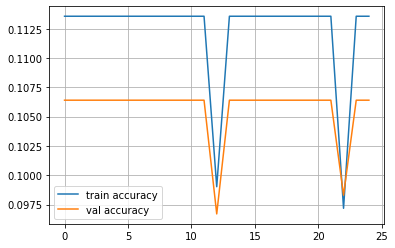

In [17]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network1,x_batch,y_batch)
    
    train_log1.append(np.mean(predict(network1,X_train)==y_train))
    val_log1.append(np.mean(predict(network1,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log1[-1])
    print("Val accuracy:",val_log1[-1])
    plt.plot(train_log1,label='train accuracy')
    plt.plot(val_log1,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.99598
Val accuracy: 0.9764


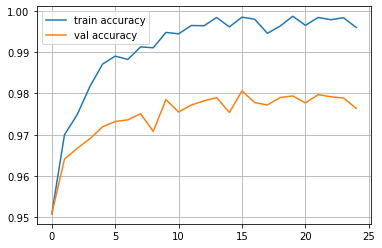

In [18]:
#################### with Xavier Initialization

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network2,x_batch,y_batch)
    
    train_log2.append(np.mean(predict(network2,X_train)==y_train))
    val_log2.append(np.mean(predict(network2,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log2[-1])
    print("Val accuracy:",val_log2[-1])
    plt.plot(train_log2,label='train accuracy')
    plt.plot(val_log2,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


Epoch 24
Train accuracy: 0.99628
Val accuracy: 0.9768


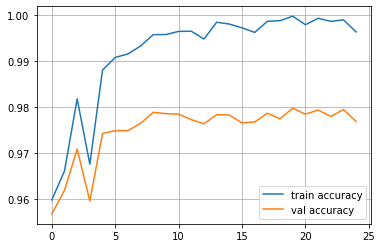

In [19]:
#################### with He Initialization

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network3,x_batch,y_batch)
    
    train_log3.append(np.mean(predict(network3,X_train)==y_train))
    val_log3.append(np.mean(predict(network3,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log3[-1])
    print("Val accuracy:",val_log3[-1])
    plt.plot(train_log3,label='train accuracy')
    plt.plot(val_log3,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

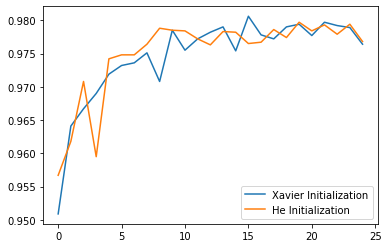

In [24]:
#plt.plot(val_log1, label = "normal network")
plt.plot(val_log2, label = "Xavier Initialization")
plt.plot(val_log3, label = "He Initialization")
plt.legend(loc='best')
plt.show()

# Discussion

In deep network(6 dense layers), N(0,0.01) distribution weight initialization leads bad result. It shows very low accuracy.

However, when I use Xavier and He Initialization, it shows high accuracy (> 97%).
And those two ways don't show clear difference..